# Satisfaction Analysis

The aim is to  to analyze customer satisfaction in depth.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import sys

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import scipy.spatial.distance as sdist

sns.set(style="ticks", color_codes=True)
sns.set(style="whitegrid")

In [2]:
data = pd.read_csv('data/clean_data.csv',low_memory=False)
user_engagement = pd.read_csv('data/user_engagement.csv',low_memory=False)
user_experience = pd.read_csv('data/user_experience.csv',low_memory=False)

In [3]:
data = data.drop(['Unnamed: 0'], axis=1).groupby(['MSISDN/Number'])
user_engagement = user_engagement.drop(['Unnamed: 0','K-Means Label'], axis=1)
user_experience = user_experience.drop(['Unnamed: 0','K-Means Label'], axis=1)

In [4]:
user_engagement['avg'] = (user_engagement['dist_sessions'] + user_engagement['dist_duration'] + user_engagement['dist_total'])
user_engagement = user_engagement.drop(['dist_sessions','dist_duration','dist_total'], axis=1)

user_experience['avg'] = (user_experience['dist_throughput'] + user_experience['dist_tcp'] + user_experience['dist_rtt'])
user_experience = user_experience.drop(['dist_throughput','dist_tcp','dist_rtt'], axis=1)

In [5]:
user_sat = pd.merge(user_engagement,user_experience, on='MSISDN/Number',suffixes=('_engage','_exper'))
user_sat['avg_sat'] = (user_sat['avg_engage']+ user_sat['avg_exper'])/2

#top 10 satisfied customers
top_sat = user_sat.sort_values(by = 'avg_sat').head(10)

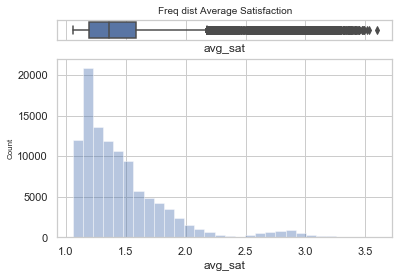

In [6]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.1, .9)})
sns.boxplot(user_sat['avg_sat'], ax=ax_box,color="b")
sns.distplot(user_sat['avg_sat'], ax=ax_hist,kde=False,bins=30,color="b")
ax_box.set_title('Freq dist Average Satisfaction' , fontsize=10)
ax_hist.set_ylabel('Count', fontsize=8)
plt.show()

In [7]:
X = user_sat.iloc[:,1:3].values
y = user_sat.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
regressor = LinearRegression()  
#training the algorithm
regressor.fit(X_train, y_train) 

# Predicting the Test set results
y_pred = regressor.predict(X_test)

ValueError: illegal value in 4-th argument of internal None

In [ ]:
results = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

In [ ]:
result_coeff = pd.DataFrame(regressor.coef_,user_sat.iloc[:,1:3].columns, columns=['Coefficient'])  
result_coeff

In [ ]:
results_samp = results.sample(30)
results_samp.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
user_sat_c = user_sat.copy()

In [ ]:
#function to normalize dataset
def spec_normalize(dataset):
    un_dataset = dataset.iloc[:,1:].values
    min_max_scaler = preprocessing.MinMaxScaler()
    dataset_scaled = min_max_scaler.fit_transform(un_dataset)
    n_dataset = pd.DataFrame(dataset_scaled,columns =[dataset.iloc[:,1:].columns] )
    n_dataset['MSISDN/Number'] = dataset['MSISDN/Number']
    return n_dataset

In [ ]:
norm_user_sat_c = spec_normalize(user_sat_c)

In [ ]:
points = norm_user_sat_c.drop(['MSISDN/Number'], axis=1)

kmeans = cluster.KMeans(n_clusters=2, random_state=0).fit(points)
norm_user_sat_c['cluster'] = kmeans.labels_

centroids = kmeans.cluster_centers_
dists = pd.DataFrame(
    sdist.cdist(points, centroids), 
    columns=['dist_{}'.format(i) for i in range(len(centroids))],
    index=norm_user_sat_c.index)

x = pd.concat([norm_user_sat_c,dists], axis=1, ignore_index=True)
x = x.rename(columns={0: "avg_engage", 1: "avg_exper",2: "avg_sat", 3:"MSISDN/Number", 4:"K-Means Label", 5: "dist_engage",7: "dist_experience",8: "dist_satisfaction"})

In [ ]:
x = x[['avg_engage','avg_exper','avg_sat','MSISDN/Number','K-Means Label']]
xp = x.copy()
xp = xp.drop(['MSISDN/Number'], axis=1)
z = x.groupby(by = ['K-Means Label'], as_index = False).agg('sum')

In [ ]:
x.to_csv('data/user_satisfaction.csv') 